### 3. MODEL BUILDING & HYPER-PARAMETER TUNING

Outcome dari model machine learning yang saya buat adalah untuk memprediksi apakah suatu pinjaman memiliki resiko **default** atau **non-default**.

* Probability default antara 0 dan 1 (0 = non default, 1 = default) 


 Probability of Default |     Interpretation       | Predicted Loan Status
 -----------------------| -----------------------  |----------------------
0.4                     | Unlikely to default      | 0
0.9                     | Very likely to default   | 1
0.1                     | Very unlikely to default | 0

**A) SPLITTING DATA**

In [36]:
X = df_clean.drop(['loan_status'], axis=1)
y = df_clean['loan_status']

**B) FEATURE SELECTION**

* **Feature selection using SelectKBest**

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # Naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  # Print 10 best features

            Specs         Score
1   person_income  3.873329e+07
3       loan_amnt  1.503011e+06
4   loan_int_rate  3.411030e+03
20   loan_grade_D  2.943448e+03
21   loan_grade_E  1.025643e+03


* **Feature selection using ExtraTreeClassifier**

[0.06125528 0.1169163  0.07492757 0.08865139 0.09102472 0.21059502
 0.05095655 0.02143012 0.00082435 0.01357581 0.03645719 0.0216673
 0.01019993 0.01030863 0.01883856 0.00831099 0.00949218 0.01066795
 0.00672767 0.02262564 0.07050207 0.01944254 0.00524529 0.00347856
 0.00696686 0.00891155]


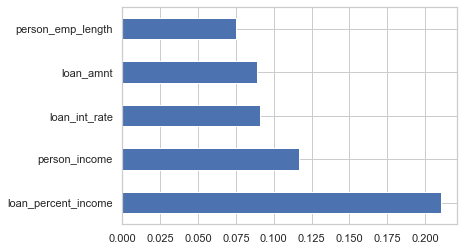

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) # Use inbuilt class feature_importances of tree based classifiers

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

**C. MODELING**

Saya akan menggunakan 3 algoritma ML, yaitu:
    1. Logistic Regression
    2. Random Forest Classifier
    3. XGBoost

In [39]:
# Load Library
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings("ignore")

**1) LOGISTIC REGRESSION**

In [40]:
# Create X and y data for the model use result of feature selection with ExtraTreeClassifier
X = df_clean[['loan_percent_income','person_income','loan_int_rate','loan_amnt','person_emp_length']]
y = df_clean['loan_status']

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Create and train a new logistic regression
log_reg = LogisticRegression().fit(X_train, y_train)

# Print the intercept of the model
print(log_reg.intercept_)

# Print the coeficient of the model
print(log_reg.coef_)

[-1.94530645e-09]
[[ 2.67963667e-09 -4.12701078e-05  9.75995839e-08  1.09127973e-04
  -2.29757337e-08]]


In [41]:
# Create predictions of probability for loan status using test data
lr_preds = log_reg.predict_proba(X_test)

# Create dataframes of first ten predictions, and first ten true labels
lr_preds_df = pd.DataFrame(lr_preds[:,1][:10], columns = ['prob_default'])
lr_true_df = y_test.head(10)

# Concatenate and print the two data frames for comparison
print(pd.concat([lr_true_df.reset_index(drop = True), lr_preds_df], axis = 1))

   loan_status  prob_default
0            0      0.313930
1            0      0.000657
2            0      0.243339
3            0      0.432167
4            0      0.220640
5            0      0.395772
6            0      0.264517
7            0      0.318181
8            0      0.142722
9            1      0.439584


**Kesimpulan:**

Berdasarkan hasil comparison diatas ada yang probability of defaultnya 0.43 tapi aktualnya adalah 0 (non-default) ada juga yang aktualnya 1 (default). Oleh karena itu, saya coba menentukan treshold di titik mana suatu prediksi termasuk non-default atau default lalu dicompare ulang dengan menggunakan confusion matrix dan classification report.

* **Treshold = 0.5**

    Apabila hasil predict_proba > 0.5 maka termasuk **default**.

In [42]:
# Create a dataframe for the probabilities of default
lr_preds_df = pd.DataFrame(lr_preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
lr_preds_df['loan_status'] = lr_preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
print(confusion_matrix(y_test, lr_preds_df['loan_status']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, lr_preds_df['loan_status'], target_names=target_names))


--------------------- Confusion Matrix ---------------------

[[7473  146]
 [1788  366]]

------------------ Classification Report -------------------

              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89      7619
     Default       0.71      0.17      0.27      2154

    accuracy                           0.80      9773
   macro avg       0.76      0.58      0.58      9773
weighted avg       0.79      0.80      0.75      9773



**Kesimpulan:**

Hasil dari recall default hanya 0.17, artinya hasil prediksi default dari model yang saya buat hanya 17% benar dari seluruh yang actualnya default. Maka dari itu saya coba untuk menurunkan treshold menjadi 0.4 untuk melihat apakah ada peningkatan recall default. 

* **Treshold = 0.4**

    Apabila hasil predict_proba > 0.4 maka termasuk **default**.

In [43]:
# Create a dataframe for the probabilities of default
lr_preds_df = pd.DataFrame(lr_preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
lr_preds_df['loan_status'] = lr_preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Print the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
print(confusion_matrix(y_test, lr_preds_df['loan_status']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, lr_preds_df['loan_status'], target_names=target_names))


--------------------- Confusion Matrix ---------------------

[[7031  588]
 [1175  979]]

------------------ Classification Report -------------------

              precision    recall  f1-score   support

 Non-Default       0.86      0.92      0.89      7619
     Default       0.62      0.45      0.53      2154

    accuracy                           0.82      9773
   macro avg       0.74      0.69      0.71      9773
weighted avg       0.81      0.82      0.81      9773



**Kesimpulan:**

Terdapat peningkatan recall default dari 0.17 ke 0.46. 

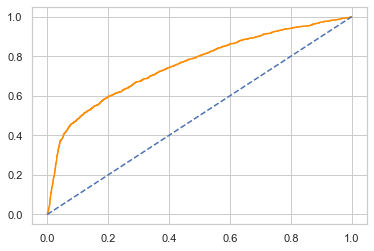

Accuracy Score: 0.8021078481530748
AUC Score: 0.7563946082114268


In [44]:
# Plot the ROC curve of the probabilities of default
lr_prob_default = lr_preds[:,1]
fallout, sensitivity, thresholds = roc_curve(y_test, lr_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Print the accuracy score the model
lr_acc_score = log_reg.score(X_test, y_test)
print('Accuracy Score: ' + str(lr_acc_score))

# Compute the AUC and store it in a variable
lr_auc_score = roc_auc_score(y_test, lr_prob_default)
print('AUC Score: ' + str(lr_auc_score))

**DEFAULT RECALL IMPACT**

Menghitung **unexpected loss** berdasarkan **default recall**.

   **Treshold = 0.4**

In [45]:
# Print the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
print(confusion_matrix(y_test, lr_preds_df['loan_status']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, lr_preds_df['loan_status'], target_names=target_names))

# Print average loan amount
print('\n' + '\033[1m' + ' Average Loan Amount '.center(60,'-') + '\033[0m' + '\n')
print(df_clean['loan_amnt'].mean())


--------------------- Confusion Matrix ---------------------

[[7031  588]
 [1175  979]]

------------------ Classification Report -------------------

              precision    recall  f1-score   support

 Non-Default       0.86      0.92      0.89      7619
     Default       0.62      0.45      0.53      2154

    accuracy                           0.82      9773
   macro avg       0.74      0.69      0.71      9773
weighted avg       0.81      0.82      0.81      9773


------------------- Average Loan Amount --------------------

9588.018051206484


Dari hasil confusion matrix dan classification report di atas diketahui:

- Number True of Default = **1406** (Hasil dari TP + FN)

- Recall Default = **46%** (Hasil dari TP / (TP + FN))

- Not Predicted = **54%** 

Loan Amount | Default Predicted / Not Predicted| Estimated Loss on Default
------------|----------------------------------|----------------------------
$ 9588      |       0.46/0.54                  | (1406 x 0.54) x 9588   
                                               
                                                                                   $7.279.593

**Treshold = 0.5**

In [46]:
# Average loan amount
avg_loan_amnt = df_clean['loan_amnt'].mean() 

# Reassign the values of loan status based on the new threshold
lr_preds_df['loan_status'] = lr_preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Store the number of actual loan defaults 
num_defaults = y_test.value_counts()[1]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test, lr_preds_df['loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
print(num_defaults * avg_loan_amnt * (1 - default_recall))

17143376.27555719


In [47]:
# Selisih antara treshold 0.5 dengan treshold 0.4
7279593 - 17143376 

-9863783

**Kesimpulan:**

Terdapat perbedaan yang signifikan antara treshold 0.5 dan treshold 0.4. Hal ini sangat penting untuk meningkatkan recall default agar bisa mengurangi potensi kerugian perusahaan.  

**THRESHOLD SELECTION**

In [48]:
# plt.plot(thresh, def_recalls)
# plt.plot(thresh, nondef_recalls)
# plt.plot(thresh, accs)
# plt.xlabel('Probability Threshold')
# plt.xticks(ticks)
# plt.legend(['Default Recall','Non-default Recall','Model Accuracy'])
# plt.show()

**2) RANDOM FOREST CLASSIFIER**

In [49]:
# Create a new Random Forest
rfc = RandomForestClassifier().fit(X_train, y_train)

# Predict with a model
rfc_preds = rfc.predict_proba(X_test)

# Create dataframes of first ten predictions, and first ten true labels
rfc_preds_df = pd.DataFrame(rfc_preds[:,1][0:10], columns = ['prob_default'])
rfc_true_df = y_test.head(10)

# Concatenate and print the two data frames for comparison
print(pd.concat([rfc_true_df.reset_index(drop = True), rfc_preds_df], axis = 1))

   loan_status  prob_default
0            0          0.21
1            0          0.07
2            0          0.02
3            0          0.32
4            0          0.03
5            0          0.21
6            0          0.02
7            0          0.22
8            0          0.00
9            1          0.55


**Treshold = 0.5**

In [50]:
# Create a dataframe for the probabilities of default
rfc_preds_df = pd.DataFrame(rfc_preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
rfc_preds_df['loan_status'] = rfc_preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
print(confusion_matrix(y_test, rfc_preds_df['loan_status']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, rfc_preds_df['loan_status'], target_names=target_names))


--------------------- Confusion Matrix ---------------------

[[7204  415]
 [ 805 1349]]

------------------ Classification Report -------------------

              precision    recall  f1-score   support

 Non-Default       0.90      0.95      0.92      7619
     Default       0.76      0.63      0.69      2154

    accuracy                           0.88      9773
   macro avg       0.83      0.79      0.81      9773
weighted avg       0.87      0.88      0.87      9773



**Treshold = 0.4**

In [51]:
# Create a dataframe for the probabilities of default
rfc_preds_df = pd.DataFrame(rfc_preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
rfc_preds_df['loan_status'] = rfc_preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Print the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
print(confusion_matrix(y_test, rfc_preds_df['loan_status']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, rfc_preds_df['loan_status'], target_names=target_names))


--------------------- Confusion Matrix ---------------------

[[7016  603]
 [ 657 1497]]

------------------ Classification Report -------------------

              precision    recall  f1-score   support

 Non-Default       0.91      0.92      0.92      7619
     Default       0.71      0.69      0.70      2154

    accuracy                           0.87      9773
   macro avg       0.81      0.81      0.81      9773
weighted avg       0.87      0.87      0.87      9773



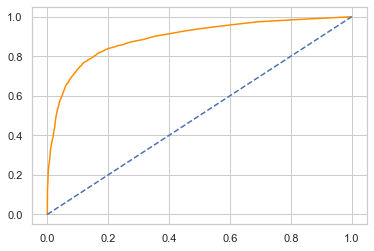

Accuracy Score: 0.8751662744295508
AUC Score: 0.8918103570668208


In [52]:
# Plot the ROC curve of the probabilities of default
rfc_prob_default = rfc_preds[:,1]
fallout, sensitivity, thresholds = roc_curve(y_test, rfc_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Print the accuracy score the model
rfc_acc_score = rfc.score(X_test, y_test)
print('Accuracy Score: ' + str(rfc_acc_score))

# Compute the AUC and store it in a variable
rfc_auc_score = roc_auc_score(y_test, rfc_prob_default)
print('AUC Score: ' + str(rfc_auc_score))

**3) XGBOOST**

In [53]:
# Create a new XGBoost
gbt = xgb.XGBClassifier().fit(X_train, y_train)

# Predict with a model
gbt_preds = gbt.predict_proba(X_test)

# Create dataframes of first ten predictions, and first ten true labels
gbt_preds_df = pd.DataFrame(gbt_preds[:,1][0:10], columns = ['prob_default'])
gbt_true_df = y_test.head(10)

# Concatenate and print the two data frames for comparison
print(pd.concat([gbt_true_df.reset_index(drop = True), gbt_preds_df], axis = 1))

   loan_status  prob_default
0            0      0.375797
1            0      0.016076
2            0      0.084966
3            0      0.092744
4            0      0.024453
5            0      0.121078
6            0      0.042531
7            0      0.228830
8            0      0.004935
9            1      0.616500


In [54]:
# Print the column importances from the model
print(gbt.get_booster().get_score(importance_type = 'weight'))

{'loan_percent_income': 529, 'loan_int_rate': 880, 'person_income': 1230, 'person_emp_length': 499, 'loan_amnt': 443}


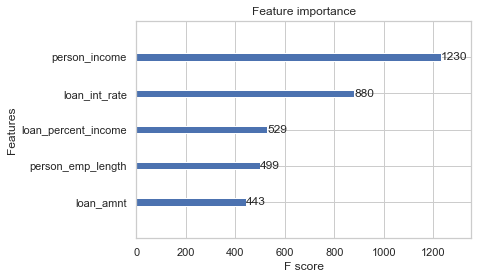

In [55]:
xgb.plot_importance(gbt, importance_type = 'weight')
plt.show()

**Treshold = 0.5**

In [56]:
# Create a dataframe for the probabilities of default
gbt_preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
gbt_preds_df['loan_status'] = gbt_preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
print(confusion_matrix(y_test, gbt_preds_df['loan_status']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, gbt_preds_df['loan_status'], target_names=target_names))


--------------------- Confusion Matrix ---------------------

[[7158  461]
 [ 765 1389]]

------------------ Classification Report -------------------

              precision    recall  f1-score   support

 Non-Default       0.90      0.94      0.92      7619
     Default       0.75      0.64      0.69      2154

    accuracy                           0.87      9773
   macro avg       0.83      0.79      0.81      9773
weighted avg       0.87      0.87      0.87      9773



**Treshold = 0.4**

In [57]:
# Create a dataframe for the probabilities of default
gbt_preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
gbt_preds_df['loan_status'] = gbt_preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

## Print the confusion matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
print(confusion_matrix(y_test, gbt_preds_df['loan_status']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, gbt_preds_df['loan_status'], target_names=target_names))


--------------------- Confusion Matrix ---------------------

[[7023  596]
 [ 642 1512]]

------------------ Classification Report -------------------

              precision    recall  f1-score   support

 Non-Default       0.92      0.92      0.92      7619
     Default       0.72      0.70      0.71      2154

    accuracy                           0.87      9773
   macro avg       0.82      0.81      0.81      9773
weighted avg       0.87      0.87      0.87      9773



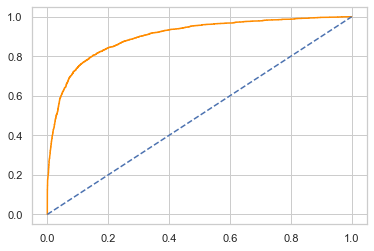

Accuracy Score: 0.8745523380742863
AUC Score: 0.9013788404422652


In [58]:
# Plot the ROC curve of the probabilities of default
gbt_prob_default = gbt_preds[:,1]
fallout, sensitivity, thresholds = roc_curve(y_test, gbt_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Print the accuracy score the model
gbt_acc_score = gbt.score(X_test, y_test)
print('Accuracy Score: ' + str(gbt_acc_score))

# Compute the AUC and store it in a variable
gbt_auc_score = roc_auc_score(y_test, gbt_prob_default)
print('AUC Score: ' + str(gbt_auc_score))

* **SCORE COMPARISON**

In [59]:
compare2 = pd.DataFrame([lr_acc_score, gbt_acc_score, rfc_acc_score, lr_auc_score, gbt_auc_score, rfc_auc_score]).transpose()
compare2.rename(columns={0 : 'lr_acc_score', 1 : 'gbt_acc_score', 2 : 'rfc_acc_score', 3: 'lr_auc_score', 
                         4 :'gbt_auc_score', 5 : 'rfc_auc_score'})

,lr_acc_score,gbt_acc_score,rfc_acc_score,lr_auc_score,gbt_auc_score,rfc_auc_score
0,0.802108,0.874552,0.875166,0.756395,0.901379,0.89181


**E) CROSS VALIDATION**

**1) XGBOOST CROSS VALIDATION**

In [60]:
# Set parameter
params = {'objective': 'binary:logistic', 'seed': 123, 'eval_metric': 'auc'}

# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, DTrain, num_boost_round = 100, nfold=n_folds,
            early_stopping_rounds=early_stopping)

# Print the cross validations data frame
print(cv_df[:10])

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.880458       0.001840       0.873056      0.006843
1        0.888024       0.002274       0.880204      0.006839
2        0.890962       0.002305       0.883168      0.007267
3        0.892705       0.001893       0.884017      0.007879
4        0.895325       0.002007       0.886104      0.007219
5        0.897359       0.002219       0.886909      0.007133
6        0.899890       0.002009       0.888087      0.006675
7        0.903071       0.002913       0.889345      0.006059
8        0.905549       0.002254       0.890574      0.006469
9        0.907999       0.002149       0.891853      0.006219


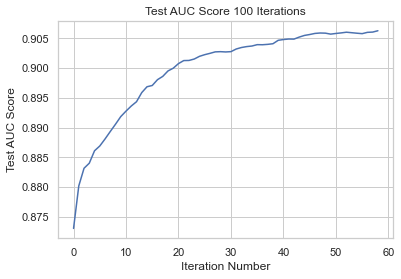

In [61]:
# Plot the test AUC scores for each iteration
plt.plot(cv_df['test-auc-mean'])
plt.title('Test AUC Score 100 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

**Kesimpulan:**

**train-auc-mean** dan **test-auc-mean** meningkat pada setiap iterasi cross-validation. 

**F) HYPER-PARAMATER TUNING**

**1) LOGISTIC REGRESSION + HYPER-PARAMETER TUNING**

In [62]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [1, 10, 100, 1000, 10000]

params = {'penalty': penalty, 'solver': solver, 'max_iter': max_iter}
params

{'penalty': ['l1', 'l2', 'elasticnet', 'none'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
 'max_iter': [1, 10, 100, 1000, 10000]}

In [63]:
model_lr = LogisticRegression()
model_lr_gs = GridSearchCV(model_lr, params, cv = 5)

In [64]:
model_lr_gs.fit(X_train, y_train)
model_lr_gs.best_params_

{'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

In [65]:
# Create and train a new logistic regression
log_reg_hyper = LogisticRegression(max_iter=1000, penalty='l2', solver='newton-cg').fit(X_train, y_train)

# Print the intercept of the model
print(log_reg_hyper.intercept_)

# Print the coeficient of the model
print(log_reg_hyper.coef_)

[-6.03653221]
[[ 1.09052214e+01 -1.85325864e-06  3.10069397e-01 -7.79555323e-05
  -2.50145290e-02]]


In [66]:
# Create predictions of probability for loan status using test data
lr_preds_hyper = log_reg_hyper.predict_proba(X_test)

# Create dataframes of first ten predictions, and first ten true labels
lr_preds_df_hyper = pd.DataFrame(lr_preds_hyper[:,1][:10], columns = ['prob_default'])
lr_true_df_hyper = y_test.head(10)

# Concatenate and print the two data frames for comparison
print(pd.concat([lr_true_df_hyper.reset_index(drop = True), lr_preds_df_hyper], axis = 1))

   loan_status  prob_default
0            0      0.275231
1            0      0.060116
2            0      0.183292
3            0      0.272013
4            0      0.052242
5            0      0.608369
6            0      0.088503
7            0      0.115451
8            0      0.032812
9            1      0.567121


In [67]:
# Create a dataframe for the probabilities of default
lr_preds_df_hyper = pd.DataFrame(lr_preds_hyper[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
lr_preds_df_hyper['loan_status'] = lr_preds_df_hyper['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Print the confusion_matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
print(confusion_matrix(y_test, lr_preds_df_hyper['loan_status']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, lr_preds_df_hyper['loan_status'], target_names=target_names))


--------------------- Confusion Matrix ---------------------

[[6921  698]
 [1029 1125]]

------------------ Classification Report -------------------

              precision    recall  f1-score   support

 Non-Default       0.87      0.91      0.89      7619
     Default       0.62      0.52      0.57      2154

    accuracy                           0.82      9773
   macro avg       0.74      0.72      0.73      9773
weighted avg       0.81      0.82      0.82      9773



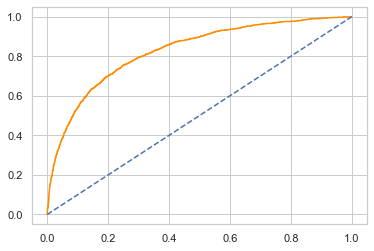

Accuracy Score: 0.8745523380742863
AUC Score: 0.8267643028966702


In [68]:
# Plot the ROC curve of the probabilities of default
lr_prob_default_hyper = lr_preds_hyper[:,1]
fallout, sensitivity, thresholds = roc_curve(y_test, lr_prob_default_hyper)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Print the accuracy score the model
lr_acc_score_hyper = gbt.score(X_test, y_test)
print('Accuracy Score: ' + str(lr_acc_score_hyper))

# Compute the AUC and store it in a variable
lr_auc_score_hyper = roc_auc_score(y_test, lr_prob_default_hyper)
print('AUC Score: ' + str(lr_auc_score_hyper))

**Kesimpulan:**

Ada peningkatan performa model machine learning setelah hyper-parameter tuning

**2) XGBOOST + HYPER-PARAMETER TUNING**

In [69]:
# Define estimator
estimator = xgb.XGBClassifier()

# Define parameter
parameters = {
    'max_depth': range(2, 10, 1),
    'n_estimators': range(10, 100, 10),
    'learning_rate': [0.1, 0.01, 0.05]
}

# Hyper-parameter tuning using GridSearch
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 5,
    cv = 5,
    verbose=True
)

In [70]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   15.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed:  9.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, 

In [71]:
print(grid_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=90, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [81]:
# Create and train a new XGBoost
gbt_hyper = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None).fit(X_train, y_train)

# Create predictions of probability for loan status using test data
gbt_preds_hyper = gbt_hyper.predict_proba(X_test)

# Create dataframes of first ten predictions, and first ten true labels
gbt_preds_df_hyper = pd.DataFrame(gbt_preds_hyper[:,1][:10], columns = ['prob_default'])
gbt_true_df_hyper = y_test.head(10)

# Concatenate and print the two data frames for comparison
print(pd.concat([gbt_true_df_hyper.reset_index(drop = True), gbt_preds_df_hyper], axis = 1))

   loan_status  prob_default
0            0      0.319005
1            0      0.020656
2            0      0.105806
3            0      0.116533
4            0      0.044460
5            0      0.154215
6            0      0.046510
7            0      0.129359
8            0      0.004794
9            1      0.642298


In [82]:
# Create a dataframe for the probabilities of default
gbt_preds_df_hyper = pd.DataFrame(gbt_preds_hyper[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
gbt_preds_df_hyper['loan_status'] = gbt_preds_df_hyper['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Print the confusion_matrix
print('\n' + '\033[1m' + ' Confusion Matrix '.center(60,'-') + '\033[0m' + '\n')
print(confusion_matrix(y_test, gbt_preds_df_hyper['loan_status']))

# Print the classification report
target_names = ['Non-Default', 'Default']
print('\n' + '\033[1m' + ' Classification Report '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, gbt_preds_df_hyper['loan_status'], target_names=target_names))


--------------------- Confusion Matrix ---------------------

[[7034  585]
 [ 632 1522]]

------------------ Classification Report -------------------

              precision    recall  f1-score   support

 Non-Default       0.92      0.92      0.92      7619
     Default       0.72      0.71      0.71      2154

    accuracy                           0.88      9773
   macro avg       0.82      0.81      0.82      9773
weighted avg       0.87      0.88      0.87      9773



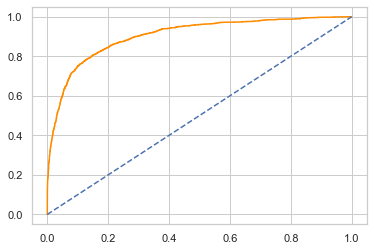

Accuracy Score: 0.8745523380742863
AUC Score: 0.9037039115547396


In [74]:
# Plot the ROC curve of the probabilities of default
gbt_prob_default_hyper = gbt_preds_hyper[:,1]
fallout, sensitivity, thresholds = roc_curve(y_test, gbt_prob_default_hyper)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Print the accuracy score the model
gbt_acc_score_hyper = gbt.score(X_test, y_test)
print('Accuracy Score: ' + str(gbt_acc_score_hyper))

# Compute the AUC and store it in a variable
gbt_auc_score_hyper = roc_auc_score(y_test, gbt_prob_default_hyper)
print('AUC Score: ' + str(gbt_auc_score_hyper))

**Kesimpulan:**

Ada sedikit peningkatan performa model machine learning setelah hyper-parameter tuning.

### 4. MODEL EVALUATION & IMPLEMENTATION

* **COMPARING MODEL REPORT**

In [75]:
# Print the logistic regression classification report
print('\n' + '\033[1m' + ' Logistic Regression '.center(60,'-') + '\033[0m' + '\n')
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, lr_preds_df_hyper['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print('\n' + '\033[1m' + ' XGBoost '.center(60,'-') + '\033[0m' + '\n')
print(classification_report(y_test, gbt_preds_df_hyper['loan_status'], target_names=target_names))


------------------- Logistic Regression --------------------

              precision    recall  f1-score   support

 Non-Default       0.87      0.91      0.89      7619
     Default       0.62      0.52      0.57      2154

    accuracy                           0.82      9773
   macro avg       0.74      0.72      0.73      9773
weighted avg       0.81      0.82      0.82      9773


------------------------- XGBoost --------------------------

              precision    recall  f1-score   support

 Non-Default       0.92      0.92      0.92      7619
     Default       0.72      0.71      0.71      2154

    accuracy                           0.88      9773
   macro avg       0.82      0.81      0.82      9773
weighted avg       0.87      0.88      0.87      9773



* **COMPARING WITH ROC**

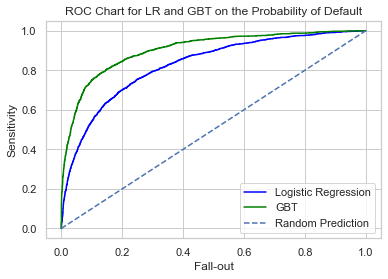

In [76]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, lr_preds_hyper[:,1])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, gbt_preds_hyper[:,1])

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

#### ACCEPTANCE RATES

Menentukan presentase penerimaan pinjaman baru (accepted loan).

In [77]:
# Check the statistics of the probabilities of default
print(gbt_preds_df_hyper['prob_default'].describe())
print('\n')

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(gbt_preds_df_hyper['prob_default'], 0.85)

# Apply acceptance rate threshold
gbt_preds_df_hyper['loan_status_accepted'] = gbt_preds_df_hyper['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the total loan accepted
print('Total loan received is')
print(sum(gbt_preds_df_hyper['loan_status_accepted'].value_counts()))
print('\n')

# Print the counts of loan status accepted
print('loan_status')
print(gbt_preds_df_hyper['loan_status_accepted'].value_counts())

count    9773.000000
mean        0.220849
std         0.290213
min         0.001138
25%         0.025090
50%         0.072648
75%         0.303732
max         0.998779
Name: prob_default, dtype: float64


Total loan received is
9773


loan_status
0    8307
1    1466
Name: loan_status_accepted, dtype: int64


**Kesimpulan:**

Dari seluruh total pinjaman yang diterima ada 8307 yang statusnya non-default dan 1466 default.

**BAD RATES**

Menghitung persentase pinjaman **default** dari total pinjaman yang diterima.

In [78]:
# Create a subset of only accepted loans
num_of_default = gbt_preds_df_hyper[gbt_preds_df_hyper['loan_status_accepted'] == 1]['loan_status_accepted'].sum()
num_of_accepted_loan = gbt_preds_df_hyper['loan_status_accepted'].value_counts().sum()

# Calculate the bad rate
bad_rate = np.sum(num_of_default / num_of_accepted_loan).round(2)
bad_rate

0.15